# Librerias necesarias

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import InceptionV3, ResNet50, inception_v3, resnet50
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from torchvision import models, transforms

In [11]:
# Ajustar paths a los datasets
cats_path = 'Dataset/cats'
dogs_path = 'Dataset/dogs'

# Cargar datasets
dataset = image_dataset_from_directory(
    'Dataset',
    image_size=(299, 299), # Tamaño de imagen para InceptionV3
    batch_size=32,
    label_mode='int'
)

# Obtener una muestra de imágenes para la explicabilidad con LIME
sample_images = []
for images, labels in dataset.take(1):
    sample_images.extend(images.numpy())
    if len(sample_images) >= 2:
        break

Found 8 files belonging to 2 classes.


In [32]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

# Inception V3

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


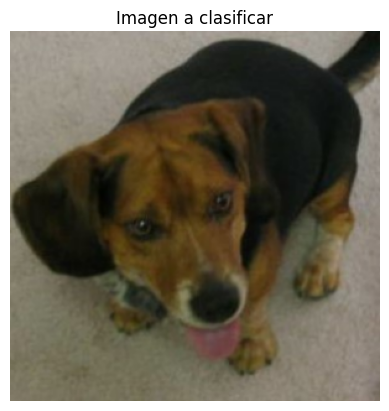

Predicciones InceptionV3:
beagle (67.80%)
bluetick (5.06%)
English_foxhound (3.56%)
Walker_hound (3.04%)
black-and-tan_coonhound (1.86%)


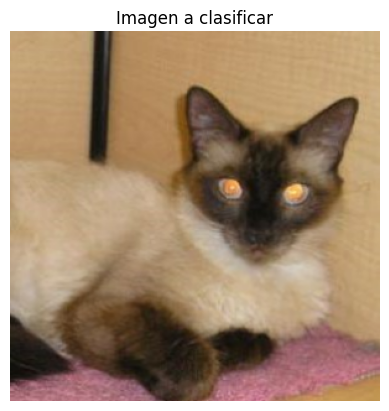

Predicciones InceptionV3:
Siamese_cat (96.76%)
Egyptian_cat (0.37%)
indri (0.07%)
lynx (0.03%)
paper_towel (0.03%)


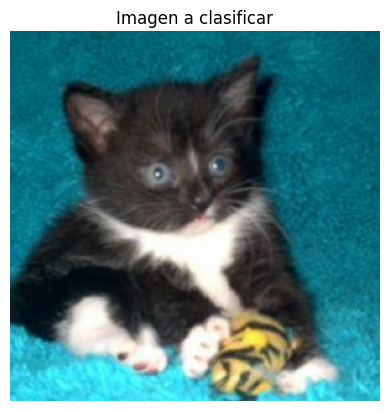

Predicciones InceptionV3:
Persian_cat (18.39%)
doormat (12.75%)
Egyptian_cat (6.97%)
Siamese_cat (1.98%)
tabby (1.58%)


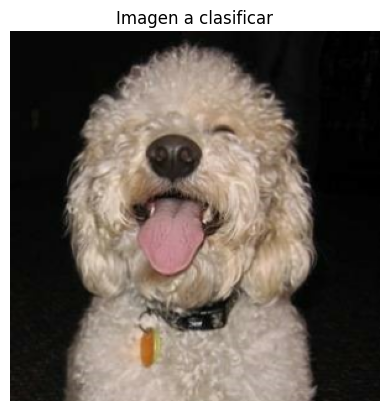

Predicciones InceptionV3:
miniature_poodle (26.18%)
Bedlington_terrier (19.20%)
Lakeland_terrier (7.16%)
wire-haired_fox_terrier (5.80%)
standard_poodle (5.06%)


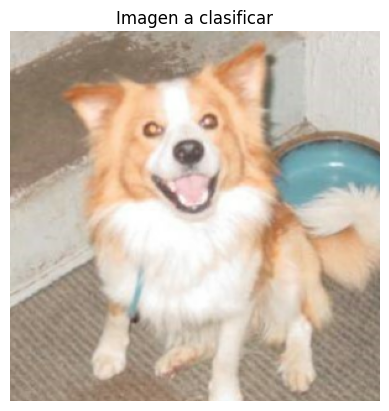

Predicciones InceptionV3:
Pembroke (46.85%)
papillon (5.74%)
collie (5.63%)
Cardigan (5.59%)
Shetland_sheepdog (2.97%)


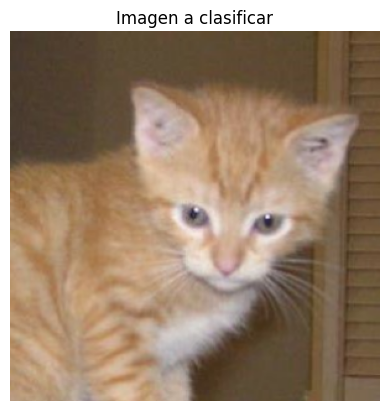

Predicciones InceptionV3:
carton (18.87%)
tiger_cat (18.41%)
tabby (9.24%)
Egyptian_cat (4.61%)
lynx (3.66%)


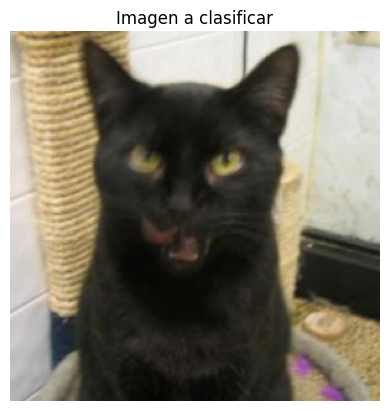

Predicciones InceptionV3:
Egyptian_cat (80.34%)
tabby (4.94%)
doormat (3.92%)
tiger_cat (1.13%)
Siamese_cat (0.53%)


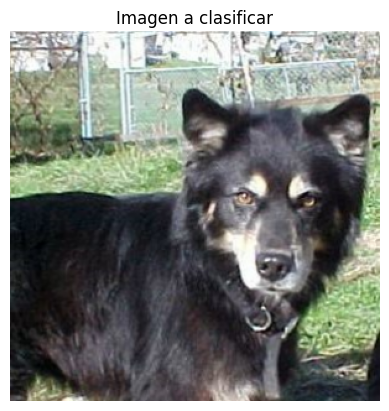

Predicciones InceptionV3:
malamute (17.89%)
Tibetan_mastiff (11.62%)
German_shepherd (6.89%)
kelpie (4.09%)
timber_wolf (4.06%)


In [15]:
# Cargar el modelo preentrenado InceptionV3
model_inception = InceptionV3(weights='imagenet')

# Función para clasificar imágenes de un dataset con InceptionV3 y mostrar la imagen
def classify_and_show_images_inception(dataset):
    for images, labels in dataset.take(1):  # Tomamos el primer batch
        preprocessed_images = preprocess_inception(images)
        predictions = model_inception.predict(preprocessed_images)
        decoded_predictions = [inception_v3.decode_predictions(np.expand_dims(pred, axis=0))[0] for pred in predictions]
        
        for i in range(len(images)):
            img = images[i]
            plt.figure()
            plt.imshow(img.numpy().astype('uint8'))
            plt.axis('off')
            plt.title('Imagen a clasificar')
            plt.show()
            
            print('Predicciones InceptionV3:')
            for (_, label, score) in decoded_predictions[i]:
                print(f'{label} ({score*100:.2f}%)')

# Clasificar imágenes y mostrar resultados
classify_and_show_images_inception(dataset)

**Interpretacion**: Según los resultados obtenidos, se observa que el modelo InceptionV3 muestra un desempeño destacado en la clasificación de imágenes de perros en comparación con las imágenes de gatos. El modelo InceptionV3 logra identificar con mayor precisión y consistencia las razas específicas de perros representadas en el dataset, reflejado en las altas probabilidades de predicción asociadas a las etiquetas correctas de clase para los perros. Sin embargo, en el caso de las imágenes de gatos, InceptionV3 presenta una menor exactitud y a veces confunde las razas, lo que sugiere una capacidad limitada para discriminar entre diferentes razas de gatos en comparación con los perros.

# ResNet50

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


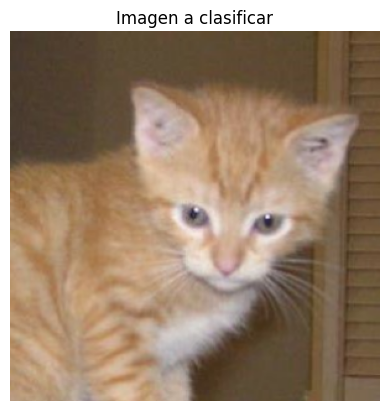

Predicciones ResNet50:
tiger_cat (28.67%)
tabby (18.65%)
window_screen (9.06%)
carton (5.86%)
washbasin (3.19%)


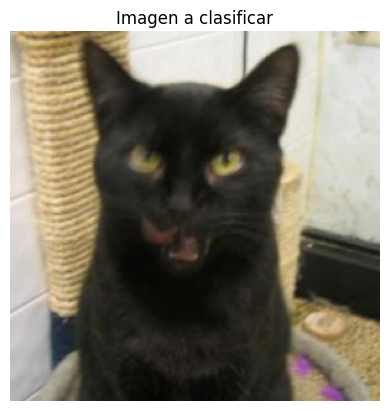

Predicciones ResNet50:
Egyptian_cat (34.18%)
hamper (12.05%)
toilet_seat (10.80%)
tabby (10.29%)
doormat (4.12%)


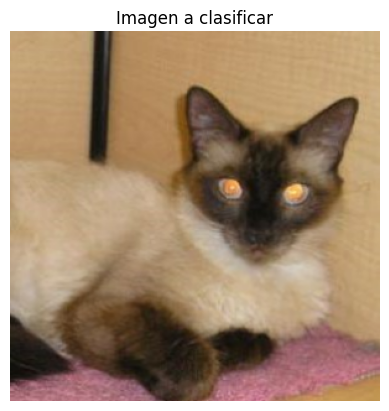

Predicciones ResNet50:
Siamese_cat (98.62%)
Egyptian_cat (0.35%)
carton (0.15%)
lynx (0.14%)
tabby (0.10%)


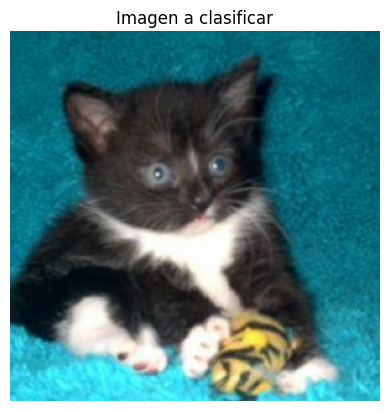

Predicciones ResNet50:
Persian_cat (10.33%)
tabby (9.09%)
Japanese_spaniel (8.66%)
Egyptian_cat (5.92%)
pool_table (5.27%)


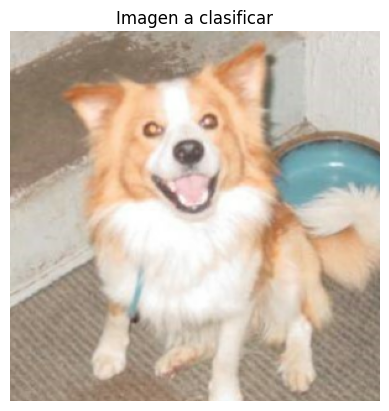

Predicciones ResNet50:
Pembroke (60.31%)
chow (7.73%)
Cardigan (6.00%)
Shetland_sheepdog (5.33%)
collie (4.51%)


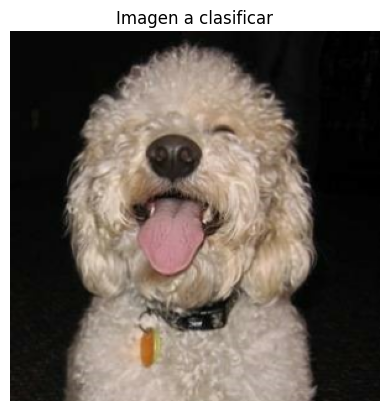

Predicciones ResNet50:
miniature_poodle (43.14%)
toy_poodle (24.97%)
standard_poodle (20.04%)
komondor (4.14%)
Bedlington_terrier (3.00%)


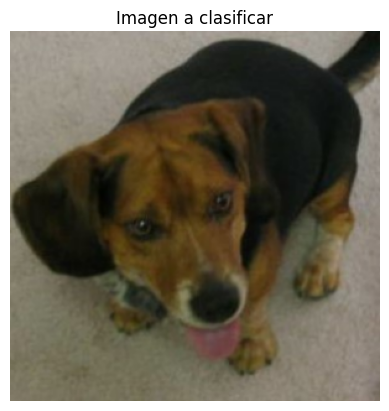

Predicciones ResNet50:
beagle (61.28%)
Walker_hound (14.32%)
English_foxhound (13.67%)
bluetick (3.68%)
basset (1.91%)


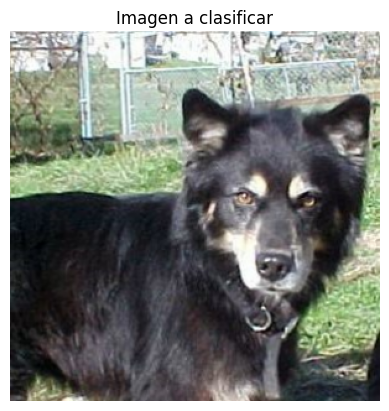

Predicciones ResNet50:
kelpie (50.72%)
Border_collie (12.27%)
dingo (5.37%)
Tibetan_mastiff (2.83%)
German_shepherd (2.76%)


In [16]:
# Cargar el modelo preentrenado ResNet50
model_resnet = ResNet50(weights='imagenet')

# Función para clasificar imágenes de un dataset con ResNet50 y mostrar la imagen
def classify_and_show_images_resnet(dataset):
    for images, labels in dataset.take(1):  # Tomamos el primer batch
        images_resized = tf.image.resize(images, (224, 224))
        preprocessed_images = preprocess_resnet(images_resized)
        predictions = model_resnet.predict(preprocessed_images)
        decoded_predictions = [resnet50.decode_predictions(np.expand_dims(pred, axis=0))[0] for pred in predictions]
        
        for i in range(len(images)):
            img = images[i]
            plt.figure()
            plt.imshow(img.numpy().astype('uint8'))
            plt.axis('off')
            plt.title('Imagen a clasificar')
            plt.show()
            
            print('Predicciones ResNet50:')
            for (_, label, score) in decoded_predictions[i]:
                print(f'{label} ({score*100:.2f}%)')

# Clasificar imágenes y mostrar resultados
classify_and_show_images_resnet(dataset)


**Interpretacion**: Se observó que ResNet50 demostró una clasificación más precisa y consistente para ambas clases de imágenes, exhibiendo una mayor capacidad para distinguir características distintivas en los gatos y perros representados en el dataset. Esto se reflejó en las probabilidades de predicción más altas asociadas a las etiquetas correctas de clase.

# Análisis de explicabilidad con LIME

In [28]:
from torchvision import transforms
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf
pill_transf = get_pil_transform()

## Análisis de Explicabilidad con LIME para InceptionV3

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


  1%|          | 10/1000 [00:00<01:16, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


  2%|▏         | 20/1000 [00:01<01:13, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


  3%|▎         | 30/1000 [00:02<01:09, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


  4%|▍         | 40/1000 [00:02<01:04, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


  5%|▌         | 50/1000 [00:03<01:02, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


  6%|▌         | 60/1000 [00:04<00:59, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  7%|▋         | 70/1000 [00:04<00:59, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  8%|▊         | 80/1000 [00:05<00:59, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


  9%|▉         | 90/1000 [00:06<01:01, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 10%|█         | 100/1000 [00:06<00:59, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


 11%|█         | 110/1000 [00:07<00:58, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


 12%|█▏        | 120/1000 [00:07<00:57, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


 13%|█▎        | 130/1000 [00:08<00:55, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


 14%|█▍        | 140/1000 [00:09<00:54, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 15%|█▌        | 150/1000 [00:09<00:53, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 16%|█▌        | 160/1000 [00:10<00:52, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 17%|█▋        | 170/1000 [00:11<00:52, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


 18%|█▊        | 180/1000 [00:11<00:51, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 19%|█▉        | 190/1000 [00:12<00:50, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 20%|██        | 200/1000 [00:12<00:49, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 21%|██        | 210/1000 [00:13<00:48, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 22%|██▏       | 220/1000 [00:14<00:48, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 23%|██▎       | 230/1000 [00:14<00:49, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 24%|██▍       | 240/1000 [00:15<00:50, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


 25%|██▌       | 250/1000 [00:16<00:49, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 26%|██▌       | 260/1000 [00:16<00:48, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


 27%|██▋       | 270/1000 [00:17<00:46, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 28%|██▊       | 280/1000 [00:18<00:44, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


 29%|██▉       | 290/1000 [00:18<00:44, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


 30%|███       | 300/1000 [00:19<00:43, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 31%|███       | 310/1000 [00:19<00:44, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


 32%|███▏      | 320/1000 [00:20<00:42, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


 33%|███▎      | 330/1000 [00:21<00:41, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 34%|███▍      | 340/1000 [00:21<00:42, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


 35%|███▌      | 350/1000 [00:22<00:41, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 36%|███▌      | 360/1000 [00:23<00:39, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 37%|███▋      | 370/1000 [00:23<00:38, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


 38%|███▊      | 380/1000 [00:24<00:37, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


 39%|███▉      | 390/1000 [00:24<00:37, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 40%|████      | 400/1000 [00:25<00:36, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 41%|████      | 410/1000 [00:26<00:35, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 42%|████▏     | 420/1000 [00:26<00:37, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 43%|████▎     | 430/1000 [00:27<00:37, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 44%|████▍     | 440/1000 [00:28<00:38, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 45%|████▌     | 450/1000 [00:29<00:38, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 46%|████▌     | 460/1000 [00:29<00:38, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


 47%|████▋     | 470/1000 [00:30<00:36, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 48%|████▊     | 480/1000 [00:31<00:35, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 49%|████▉     | 490/1000 [00:31<00:35, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


 50%|█████     | 500/1000 [00:32<00:33, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


 51%|█████     | 510/1000 [00:33<00:32, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


 52%|█████▏    | 520/1000 [00:33<00:30, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 53%|█████▎    | 530/1000 [00:34<00:30, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


 54%|█████▍    | 540/1000 [00:34<00:29, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 55%|█████▌    | 550/1000 [00:35<00:29, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 56%|█████▌    | 560/1000 [00:36<00:29, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 57%|█████▋    | 570/1000 [00:36<00:28, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 58%|█████▊    | 580/1000 [00:37<00:27, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 59%|█████▉    | 590/1000 [00:38<00:25, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 60%|██████    | 600/1000 [00:38<00:25, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


 61%|██████    | 610/1000 [00:39<00:25, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 62%|██████▏   | 620/1000 [00:40<00:24, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 63%|██████▎   | 630/1000 [00:40<00:23, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 64%|██████▍   | 640/1000 [00:41<00:22, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 65%|██████▌   | 650/1000 [00:41<00:22, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


 66%|██████▌   | 660/1000 [00:42<00:21, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 67%|██████▋   | 670/1000 [00:43<00:20, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 68%|██████▊   | 680/1000 [00:43<00:20, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 69%|██████▉   | 690/1000 [00:44<00:20, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


 70%|███████   | 700/1000 [00:45<00:19, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


 71%|███████   | 710/1000 [00:45<00:18, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 72%|███████▏  | 720/1000 [00:46<00:17, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 73%|███████▎  | 730/1000 [00:47<00:16, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 74%|███████▍  | 740/1000 [00:47<00:15, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 75%|███████▌  | 750/1000 [00:48<00:15, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


 76%|███████▌  | 760/1000 [00:48<00:14, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


 77%|███████▋  | 770/1000 [00:49<00:14, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


 78%|███████▊  | 780/1000 [00:50<00:13, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step


 79%|███████▉  | 790/1000 [00:50<00:12, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 80%|████████  | 800/1000 [00:51<00:12, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 81%|████████  | 810/1000 [00:51<00:11, 16.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 82%|████████▏ | 820/1000 [00:52<00:10, 16.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 83%|████████▎ | 830/1000 [00:53<00:10, 16.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 84%|████████▍ | 840/1000 [00:53<00:09, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 85%|████████▌ | 850/1000 [00:54<00:09, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 86%|████████▌ | 860/1000 [00:55<00:08, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 87%|████████▋ | 870/1000 [00:55<00:08, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 88%|████████▊ | 880/1000 [00:56<00:07, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


 89%|████████▉ | 890/1000 [00:56<00:07, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 90%|█████████ | 900/1000 [00:57<00:06, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


 91%|█████████ | 910/1000 [00:58<00:05, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 92%|█████████▏| 920/1000 [00:58<00:04, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 93%|█████████▎| 930/1000 [00:59<00:04, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 94%|█████████▍| 940/1000 [00:59<00:03, 16.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 95%|█████████▌| 950/1000 [01:00<00:03, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 96%|█████████▌| 960/1000 [01:01<00:02, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 97%|█████████▋| 970/1000 [01:02<00:02, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


 98%|█████████▊| 980/1000 [01:02<00:01, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 99%|█████████▉| 990/1000 [01:03<00:00, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


100%|██████████| 1000/1000 [01:04<00:00, 15.61it/s]


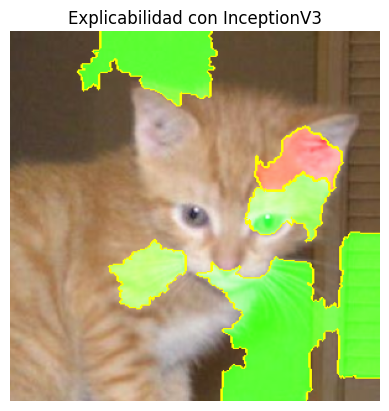

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  1%|          | 10/1000 [00:00<01:06, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  2%|▏         | 20/1000 [00:01<01:06, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  3%|▎         | 30/1000 [00:02<01:04, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


  4%|▍         | 40/1000 [00:02<01:04, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


  5%|▌         | 50/1000 [00:03<01:11, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


  6%|▌         | 60/1000 [00:04<01:11, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


  7%|▋         | 70/1000 [00:05<01:09, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


  8%|▊         | 80/1000 [00:05<01:08, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


  9%|▉         | 90/1000 [00:06<01:06, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 10%|█         | 100/1000 [00:07<01:06, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 11%|█         | 110/1000 [00:07<01:03, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 12%|█▏        | 120/1000 [00:08<01:01, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 13%|█▎        | 130/1000 [00:09<01:01, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 14%|█▍        | 140/1000 [00:10<01:01, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 15%|█▌        | 150/1000 [00:10<01:00, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 16%|█▌        | 160/1000 [00:11<00:58, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 17%|█▋        | 170/1000 [00:12<00:57, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


 18%|█▊        | 180/1000 [00:12<00:55, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 19%|█▉        | 190/1000 [00:13<00:55, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 20%|██        | 200/1000 [00:14<00:52, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 21%|██        | 210/1000 [00:14<00:50, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 22%|██▏       | 220/1000 [00:15<00:48, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 23%|██▎       | 230/1000 [00:15<00:46, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 24%|██▍       | 240/1000 [00:16<00:46, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


 25%|██▌       | 250/1000 [00:16<00:45, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


 26%|██▌       | 260/1000 [00:17<00:45, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 27%|██▋       | 270/1000 [00:18<00:44, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 28%|██▊       | 280/1000 [00:18<00:43, 16.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 29%|██▉       | 290/1000 [00:19<00:42, 16.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 30%|███       | 300/1000 [00:19<00:41, 16.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


 31%|███       | 310/1000 [00:20<00:41, 16.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 32%|███▏      | 320/1000 [00:21<00:43, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 33%|███▎      | 330/1000 [00:22<00:45, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


 34%|███▍      | 340/1000 [00:22<00:44, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


 35%|███▌      | 350/1000 [00:23<00:42, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 36%|███▌      | 360/1000 [00:23<00:40, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 37%|███▋      | 370/1000 [00:24<00:38, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 38%|███▊      | 380/1000 [00:25<00:37, 16.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 39%|███▉      | 390/1000 [00:25<00:36, 16.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 40%|████      | 400/1000 [00:26<00:35, 16.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 41%|████      | 410/1000 [00:26<00:35, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 42%|████▏     | 420/1000 [00:27<00:35, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


 43%|████▎     | 430/1000 [00:28<00:35, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 44%|████▍     | 440/1000 [00:28<00:34, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 45%|████▌     | 450/1000 [00:29<00:34, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 46%|████▌     | 460/1000 [00:30<00:34, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 47%|████▋     | 470/1000 [00:30<00:33, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 48%|████▊     | 480/1000 [00:31<00:33, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


 49%|████▉     | 490/1000 [00:31<00:32, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 50%|█████     | 500/1000 [00:32<00:30, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


 51%|█████     | 510/1000 [00:33<00:29, 16.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 52%|█████▏    | 520/1000 [00:33<00:29, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 53%|█████▎    | 530/1000 [00:34<00:28, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


 54%|█████▍    | 540/1000 [00:34<00:27, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 55%|█████▌    | 550/1000 [00:35<00:27, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


 56%|█████▌    | 560/1000 [00:36<00:26, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


 57%|█████▋    | 570/1000 [00:36<00:26, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 58%|█████▊    | 580/1000 [00:37<00:24, 16.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


 59%|█████▉    | 590/1000 [00:37<00:24, 16.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 60%|██████    | 600/1000 [00:38<00:23, 16.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


 61%|██████    | 610/1000 [00:39<00:23, 16.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 62%|██████▏   | 620/1000 [00:39<00:22, 16.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


 63%|██████▎   | 630/1000 [00:40<00:21, 16.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 64%|██████▍   | 640/1000 [00:40<00:21, 16.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 65%|██████▌   | 650/1000 [00:41<00:20, 17.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 66%|██████▌   | 660/1000 [00:42<00:19, 17.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 67%|██████▋   | 670/1000 [00:42<00:19, 16.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 68%|██████▊   | 680/1000 [00:43<00:18, 16.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 69%|██████▉   | 690/1000 [00:43<00:18, 16.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 70%|███████   | 700/1000 [00:44<00:17, 17.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 71%|███████   | 710/1000 [00:44<00:16, 17.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 72%|███████▏  | 720/1000 [00:45<00:16, 17.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 73%|███████▎  | 730/1000 [00:46<00:15, 17.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 74%|███████▍  | 740/1000 [00:46<00:15, 17.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 75%|███████▌  | 750/1000 [00:47<00:14, 16.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 76%|███████▌  | 760/1000 [00:47<00:14, 16.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 77%|███████▋  | 770/1000 [00:48<00:13, 17.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 78%|███████▊  | 780/1000 [00:49<00:12, 16.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 79%|███████▉  | 790/1000 [00:49<00:12, 16.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 80%|████████  | 800/1000 [00:50<00:11, 17.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 81%|████████  | 810/1000 [00:50<00:11, 17.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


 82%|████████▏ | 820/1000 [00:51<00:10, 16.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


 83%|████████▎ | 830/1000 [00:52<00:10, 16.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 84%|████████▍ | 840/1000 [00:52<00:09, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 85%|████████▌ | 850/1000 [00:53<00:09, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 86%|████████▌ | 860/1000 [00:54<00:08, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 88%|████████▊ | 878/1000 [00:54<00:06, 19.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 89%|████████▉ | 889/1000 [00:55<00:06, 17.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 89%|████████▉ | 893/1000 [00:56<00:08, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 90%|█████████ | 900/1000 [00:56<00:08, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


 91%|█████████ | 910/1000 [00:57<00:06, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


 92%|█████████▏| 920/1000 [00:58<00:05, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


 93%|█████████▎| 930/1000 [00:58<00:04, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 94%|█████████▍| 940/1000 [00:59<00:03, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 95%|█████████▌| 950/1000 [00:59<00:03, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 96%|█████████▌| 960/1000 [01:00<00:02, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


 97%|█████████▋| 970/1000 [01:01<00:01, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step


 98%|█████████▊| 980/1000 [01:01<00:01, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 99%|█████████▉| 990/1000 [01:02<00:00, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


100%|██████████| 1000/1000 [01:02<00:00, 15.88it/s]


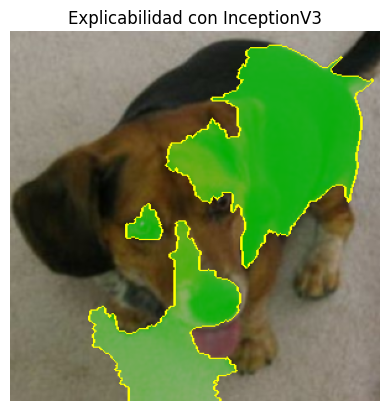

In [36]:
# Función para explicar una imagen utilizando LIME con InceptionV3
def explain_image_inception(model, img, preprocess_fn, target_size):
    explainer = lime_image.LimeImageExplainer()

    img_resized = tf.image.resize(img, target_size)
    img_array = np.expand_dims(img_resized.numpy(), axis=0)
    img_preprocessed = preprocess_fn(img_array)

    explanation = explainer.explain_instance(img_array[0], model.predict, top_labels=5, hide_color=0, num_samples=1000)
    
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title('Explicabilidad con InceptionV3')
    plt.axis('off')
    plt.show()

# Explicar una imagen de cada tipo utilizando InceptionV3
for images, labels in dataset.take(1):  # Solo tomamos el primer batch
    explain_image_inception(model_inception, images[0], preprocess_inception, (299, 299))
    explain_image_inception(model_inception, images[1], preprocess_inception, (299, 299))

**Interpretacion**:

## Análisis de Explicabilidad con LIME para ResNet50

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  1%|          | 10/1000 [00:00<01:03, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


  2%|▏         | 20/1000 [00:01<01:04, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


  3%|▎         | 30/1000 [00:01<01:04, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  4%|▍         | 40/1000 [00:02<01:04, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  5%|▌         | 50/1000 [00:03<01:03, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  6%|▌         | 60/1000 [00:03<01:03, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


  7%|▋         | 70/1000 [00:04<01:02, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


  8%|▊         | 80/1000 [00:05<01:02, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


  9%|▉         | 90/1000 [00:06<01:00, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 10%|█         | 100/1000 [00:06<00:59, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 11%|█         | 110/1000 [00:07<01:00, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 12%|█▏        | 120/1000 [00:08<00:59, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 13%|█▎        | 130/1000 [00:08<00:58, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 14%|█▍        | 140/1000 [00:09<00:57, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 15%|█▌        | 150/1000 [00:10<00:57, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 16%|█▌        | 160/1000 [00:10<00:55, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 17%|█▋        | 170/1000 [00:11<00:55, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


 18%|█▊        | 180/1000 [00:12<00:53, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 19%|█▉        | 190/1000 [00:12<00:54, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


 20%|██        | 200/1000 [00:13<00:52, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 21%|██        | 210/1000 [00:14<00:52, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 22%|██▏       | 220/1000 [00:14<00:51, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 23%|██▎       | 230/1000 [00:15<00:51, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 24%|██▍       | 240/1000 [00:15<00:50, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 25%|██▌       | 250/1000 [00:16<00:49, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


 26%|██▌       | 260/1000 [00:17<00:47, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 27%|██▋       | 270/1000 [00:17<00:48, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 28%|██▊       | 280/1000 [00:18<00:46, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 29%|██▉       | 290/1000 [00:19<00:46, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 30%|███       | 300/1000 [00:19<00:45, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 31%|███       | 310/1000 [00:20<00:45, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 32%|███▏      | 320/1000 [00:21<00:44, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 33%|███▎      | 330/1000 [00:21<00:44, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 34%|███▍      | 340/1000 [00:22<00:43, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 35%|███▌      | 350/1000 [00:23<00:45, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 36%|███▌      | 360/1000 [00:24<00:44, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step


 37%|███▋      | 370/1000 [00:24<00:48, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 38%|███▊      | 380/1000 [00:25<00:47, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 39%|███▉      | 390/1000 [00:26<00:45, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 40%|████      | 400/1000 [00:27<00:45, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 41%|████      | 410/1000 [00:27<00:45, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 42%|████▏     | 420/1000 [00:28<00:43, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 43%|████▎     | 430/1000 [00:29<00:42, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 44%|████▍     | 440/1000 [00:30<00:44, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 45%|████▌     | 450/1000 [00:31<00:42, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 46%|████▌     | 460/1000 [00:31<00:41, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 47%|████▋     | 470/1000 [00:32<00:39, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 48%|████▊     | 480/1000 [00:33<00:39, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 49%|████▉     | 490/1000 [00:34<00:37, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 50%|█████     | 500/1000 [00:34<00:36, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 51%|█████     | 510/1000 [00:35<00:35, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 52%|█████▏    | 520/1000 [00:36<00:34, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 53%|█████▎    | 530/1000 [00:36<00:32, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 54%|█████▍    | 540/1000 [00:37<00:33, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 55%|█████▌    | 550/1000 [00:38<00:32, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 56%|█████▌    | 560/1000 [00:39<00:31, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 57%|█████▋    | 570/1000 [00:39<00:30, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 58%|█████▊    | 580/1000 [00:40<00:29, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 59%|█████▉    | 590/1000 [00:41<00:28, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 60%|██████    | 600/1000 [00:41<00:28, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


 61%|██████    | 610/1000 [00:42<00:26, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 62%|██████▏   | 620/1000 [00:43<00:26, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 63%|██████▎   | 630/1000 [00:43<00:25, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 64%|██████▍   | 640/1000 [00:44<00:25, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 65%|██████▌   | 650/1000 [00:45<00:24, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 66%|██████▌   | 660/1000 [00:45<00:23, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 67%|██████▋   | 670/1000 [00:46<00:22, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 68%|██████▊   | 680/1000 [00:47<00:22, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 69%|██████▉   | 690/1000 [00:48<00:21, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 70%|███████   | 700/1000 [00:48<00:22, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 71%|███████   | 710/1000 [00:49<00:22, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 72%|███████▏  | 720/1000 [00:50<00:22, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 73%|███████▎  | 730/1000 [00:51<00:21, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 74%|███████▍  | 740/1000 [00:52<00:20, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 75%|███████▌  | 750/1000 [00:52<00:19, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 76%|███████▌  | 760/1000 [00:53<00:18, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 77%|███████▋  | 770/1000 [00:54<00:16, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 78%|███████▊  | 780/1000 [00:55<00:16, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 79%|███████▉  | 790/1000 [00:55<00:14, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 80%|████████  | 800/1000 [00:56<00:14, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 81%|████████  | 810/1000 [00:57<00:13, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 82%|████████▏ | 820/1000 [00:57<00:12, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 83%|████████▎ | 830/1000 [00:58<00:11, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 84%|████████▍ | 840/1000 [00:59<00:11, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 85%|████████▌ | 850/1000 [00:59<00:10, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 86%|████████▌ | 860/1000 [01:00<00:10, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step


 87%|████████▋ | 870/1000 [01:01<00:10, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 88%|████████▊ | 880/1000 [01:02<00:10, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 89%|████████▉ | 890/1000 [01:03<00:09, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 90%|█████████ | 900/1000 [01:04<00:07, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 91%|█████████ | 910/1000 [01:05<00:07, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 92%|█████████▏| 920/1000 [01:05<00:06, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step


 93%|█████████▎| 930/1000 [01:07<00:06, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 94%|█████████▍| 940/1000 [01:07<00:05, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 95%|█████████▌| 950/1000 [01:08<00:04, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


 96%|█████████▌| 960/1000 [01:09<00:03, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step


 97%|█████████▋| 970/1000 [01:10<00:02, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 98%|█████████▊| 980/1000 [01:11<00:01, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 99%|█████████▉| 990/1000 [01:12<00:00, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


100%|██████████| 1000/1000 [01:13<00:00, 13.64it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


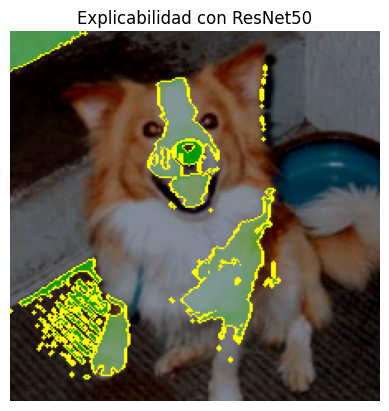

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


  2%|▏         | 19/1000 [00:00<00:42, 23.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


  3%|▎         | 29/1000 [00:01<01:04, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


  3%|▎         | 33/1000 [00:02<01:42,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


  4%|▍         | 40/1000 [00:03<01:46,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


  5%|▌         | 50/1000 [00:04<01:36,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


  6%|▌         | 60/1000 [00:05<01:32, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


  7%|▋         | 70/1000 [00:06<01:30, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


  8%|▊         | 80/1000 [00:07<01:22, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


  9%|▉         | 90/1000 [00:07<01:19, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 10%|█         | 100/1000 [00:08<01:13, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 11%|█         | 110/1000 [00:09<01:13, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 12%|█▏        | 120/1000 [00:10<01:08, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 13%|█▎        | 130/1000 [00:10<01:08, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 14%|█▍        | 140/1000 [00:11<01:05, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 15%|█▌        | 150/1000 [00:12<01:05, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 16%|█▌        | 160/1000 [00:13<01:04, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 17%|█▋        | 170/1000 [00:14<01:03, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 18%|█▊        | 180/1000 [00:14<01:00, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 19%|█▉        | 190/1000 [00:15<00:59, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 20%|██        | 200/1000 [00:16<00:58, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 21%|██        | 210/1000 [00:16<00:58, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 22%|██▏       | 220/1000 [00:17<00:56, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 23%|██▎       | 230/1000 [00:18<00:55, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 24%|██▍       | 240/1000 [00:18<00:53, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 25%|██▌       | 250/1000 [00:19<00:52, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 26%|██▌       | 260/1000 [00:20<00:50, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 27%|██▋       | 270/1000 [00:20<00:49, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


 28%|██▊       | 280/1000 [00:21<00:47, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 29%|██▉       | 290/1000 [00:22<00:47, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


 30%|███       | 300/1000 [00:22<00:46, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 31%|███       | 310/1000 [00:23<00:46, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 32%|███▏      | 320/1000 [00:24<00:45, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 33%|███▎      | 330/1000 [00:25<00:46, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 34%|███▍      | 340/1000 [00:25<00:44, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 35%|███▌      | 350/1000 [00:26<00:46, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 36%|███▌      | 360/1000 [00:27<00:45, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 37%|███▋      | 370/1000 [00:27<00:45, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 38%|███▊      | 380/1000 [00:28<00:45, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 39%|███▉      | 390/1000 [00:29<00:46, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


 40%|████      | 400/1000 [00:30<00:43, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 41%|████      | 410/1000 [00:30<00:41, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 42%|████▏     | 420/1000 [00:31<00:39, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 43%|████▎     | 430/1000 [00:32<00:38, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


 44%|████▍     | 440/1000 [00:32<00:36, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 45%|████▌     | 450/1000 [00:33<00:36, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 46%|████▌     | 460/1000 [00:33<00:34, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 47%|████▋     | 470/1000 [00:34<00:34, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


 48%|████▊     | 480/1000 [00:35<00:33, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 49%|████▉     | 490/1000 [00:35<00:33, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 50%|█████     | 500/1000 [00:36<00:32, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 51%|█████     | 510/1000 [00:37<00:33, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 52%|█████▏    | 520/1000 [00:38<00:33, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 53%|█████▎    | 530/1000 [00:38<00:33, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


 54%|█████▍    | 540/1000 [00:39<00:31, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 55%|█████▌    | 550/1000 [00:40<00:31, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 56%|█████▌    | 560/1000 [00:40<00:30, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 57%|█████▋    | 570/1000 [00:41<00:30, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


 58%|█████▊    | 580/1000 [00:42<00:28, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 59%|█████▉    | 590/1000 [00:42<00:27, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


 60%|██████    | 600/1000 [00:43<00:26, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 61%|██████    | 610/1000 [00:44<00:25, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


 62%|██████▏   | 620/1000 [00:44<00:24, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 63%|██████▎   | 630/1000 [00:45<00:23, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


 64%|██████▍   | 640/1000 [00:46<00:23, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 65%|██████▌   | 650/1000 [00:46<00:22, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 66%|██████▌   | 660/1000 [00:47<00:21, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 67%|██████▋   | 670/1000 [00:47<00:21, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 68%|██████▊   | 680/1000 [00:48<00:20, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 69%|██████▉   | 690/1000 [00:49<00:20, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 70%|███████   | 700/1000 [00:49<00:19, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 71%|███████   | 710/1000 [00:50<00:19, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 72%|███████▏  | 720/1000 [00:51<00:19, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 73%|███████▎  | 730/1000 [00:52<00:19, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 74%|███████▍  | 740/1000 [00:52<00:18, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 75%|███████▌  | 750/1000 [00:53<00:17, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 76%|███████▌  | 760/1000 [00:54<00:16, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 77%|███████▋  | 770/1000 [00:54<00:15, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 78%|███████▊  | 780/1000 [00:55<00:14, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 79%|███████▉  | 790/1000 [00:56<00:13, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


 80%|████████  | 800/1000 [00:56<00:12, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 81%|████████  | 810/1000 [00:57<00:12, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


 82%|████████▏ | 820/1000 [00:57<00:11, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 83%|████████▎ | 830/1000 [00:58<00:11, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


 84%|████████▍ | 840/1000 [00:59<00:10, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 85%|████████▌ | 850/1000 [00:59<00:09, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 86%|████████▌ | 860/1000 [01:00<00:08, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 87%|████████▋ | 870/1000 [01:01<00:08, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


 88%|████████▊ | 880/1000 [01:01<00:07, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 89%|████████▉ | 890/1000 [01:02<00:07, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 90%|█████████ | 900/1000 [01:03<00:06, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 91%|█████████ | 910/1000 [01:03<00:06, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 92%|█████████▏| 920/1000 [01:04<00:05, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 93%|█████████▎| 930/1000 [01:05<00:05, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 94%|█████████▍| 940/1000 [01:06<00:04, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 95%|█████████▌| 950/1000 [01:06<00:03, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 96%|█████████▌| 960/1000 [01:07<00:02, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 97%|█████████▋| 970/1000 [01:08<00:02, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


 98%|█████████▊| 980/1000 [01:08<00:01, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


 99%|█████████▉| 990/1000 [01:09<00:00, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


100%|██████████| 1000/1000 [01:10<00:00, 14.26it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


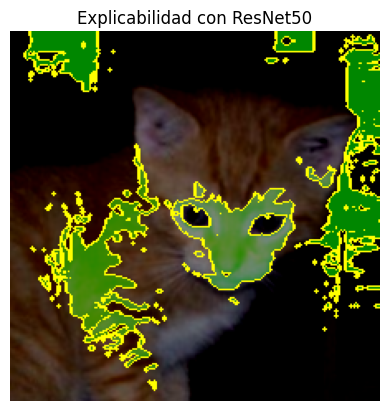

In [37]:
# Función para explicar una imagen utilizando LIME con ResNet50
def explain_image_resnet(model, img, preprocess_fn, target_size):
    explainer = lime_image.LimeImageExplainer()

    img_resized = tf.image.resize(img, target_size)
    img_array = np.expand_dims(img_resized.numpy(), axis=0)
    img_preprocessed = preprocess_fn(img_array)

    explanation = explainer.explain_instance(img_array[0], model.predict, top_labels=5, hide_color=0, num_samples=1000)
    
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title('Explicabilidad con ResNet50')
    plt.axis('off')
    plt.show()

# Explicar una imagen de cada tipo utilizando ResNet50
for images, labels in dataset.take(1):  # Solo tomamos el primer batch
    explain_image_resnet(model_resnet, images[0], preprocess_resnet, (224, 224))
    explain_image_resnet(model_resnet, images[1], preprocess_resnet, (224, 224))

**Interpretacion**: En el análisis de interpretabilidad utilizando LIME en los modelos preentrenados como ResNet50 e InceptionV3, observamos que estos modelos utilizan características específicas para distinguir entre perros y gatos. Por ejemplo, en ResNet50, el modelo parece enfocarse en características como la nariz, los ojos, las orejas y la cola del animal para realizar la clasificación. Mientras tanto, en InceptionV3, se observa que el modelo considera patrones más complejos, como la forma y textura del pelaje, así como la estructura facial del animal, para hacer sus predicciones. Esto resalta cómo cada modelo puede aprender diferentes aspectos visuales y estructurales para identificar correctamente objetos en las imágenes.